#Classificação de imagens de roupas

### Sobre o projeto

* Estudo introdutório sobre Deep Learning, TensorFlow e Keras.

* E-commerce fictício de roupas, as roupas à venda devem ser classificadas em categorias para facilitar as buscas dos clientes no site.

* **Dataset:** [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) que contém pequenas imagens (28x28) de roupas, associadas a 10 classes.

* **Referência:** Estudo desenvolvido acompanhando o curso [Deep Learning parte 1: Keras](https://cursos.alura.com.br/course/deep-learning-introducao-com-keras), da Alura.

# Abertura do dataset e primeiras visualizações

## Fashion MNIST

In [1]:
import tensorflow
from tensorflow import keras

dataset = keras.datasets.fashion_mnist

In [2]:
# retorna duas tuplas com conjuntos de treino, teste, e suas labels
((train_imgs, train_labels),(test_imgs, test_labels)) = dataset.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
print(f'Conjunto de treino possui {len(train_imgs)} imagens.')
print(f'Conjunto de teste possui {len(test_imgs)} imagens.')

Conjunto de treino possui 60000 imagens.
Conjunto de teste possui 10000 imagens.


In [4]:
print(train_imgs.shape)
print(test_imgs.shape)

(60000, 28, 28)
(10000, 28, 28)


## Classes

In [5]:
import numpy as np
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

* Os nomes das classes estão no Readme do dataset.

In [6]:
class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Visualização de alguns itens

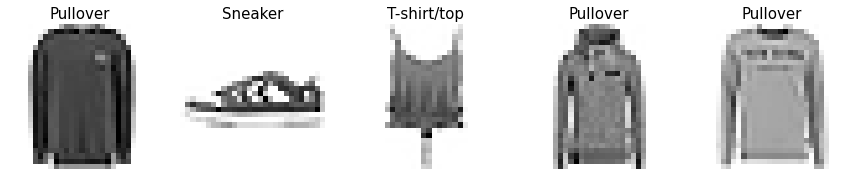

In [7]:
import random
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Greys'

fig, axs = plt.subplots(1, 5, figsize = (15, 25))

rand_ids = [random.randint(0, 60000) for i in range(5)]

for k, i in zip(range(0,5), rand_ids):
  axs[k].imshow(train_imgs[i])
  axs[k].axis('off')
  axs[k].set_title(class_name[train_labels[i]], fontsize = 15)

plt.show()

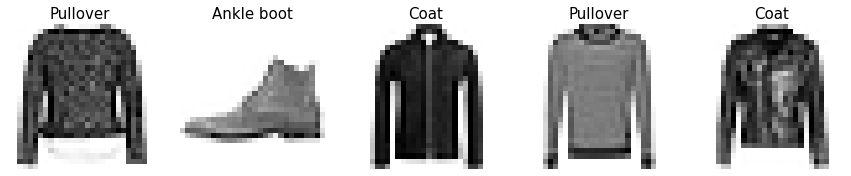

In [8]:
fig, axs = plt.subplots(1, 5, figsize = (15, 25))

rand_ids = [random.randint(0, 10000) for i in range(5)]

for k, i in zip(range(0,5), rand_ids):
  axs[k].imshow(test_imgs[i])
  axs[k].axis('off')
  axs[k].set_title(class_name[test_labels[i]], fontsize = 15)

plt.show()

# Funções de Ativação

![teste](https://miro.medium.com/max/720/1*ZafDv3VUm60Eh10OeJu1vw.webp)

## ReLu

* Todos os número negativos se tornam 0.
* A ReLu tem a possibilidade de desligar alguns neurônios.
* $a = z^+ = max(0, z)$
* É não-linear, essencial para separar mais de duas características em uma única função.

## SoftMax

* Usada da última camada.
* Atribui probabilidades de cada categoria estar correta.

* ### $a_j^{(L-1)} = \frac{exp(z_j^{(L-1)})}{∑_i exp(z_i^{(L-1)})}$

  * (L-1) ⟶ camada anterior.
  * a > 0, por do exponencial.
  * O somatório de todas as probabilidades é 1, 100%.

# Construção do Modelo

* Modelo >> entrada > processamento > saída

* Na primeira camada, Camada 0, a imagem será "achatada" para um array de pixels de uma única dimensão.

* Na Camda 1, é feita a comunicação com a camada de entrada. Neste caso, será uma camada densa, totalmente conectada com a anterior.
  * No primneiro parâmetro, são definidos quantos neurônios estarão nesta camada.É interessante utilizar múltiplos de 2 por questão de processamento.
  * Deve ser definida também a função de ativação, que neste caso será a ReLu (https://www.tensorflow.org/api_docs/python/tf/nn/relu).

* Na Camada 2, de saída, terá o número de classificações do dataset e totalmente conectada.

In [9]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),               # camada 0, entrada
    keras.layers.Dense(256, activation = tensorflow.nn.relu),   # camada 1, escondida
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)  # camada 2, saída
])

In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')

* O batch_size padrão é 32, por isso a quantidade que aparece no log não é o tamanho completo do dataset, mas sim esse valor dividido por 32. Todo o dataset é usado no treinamento, mas em grupos menores.

In [11]:
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 11s 5ms/step - loss: 3.7775


* O ideal é que a perda esteja o mais próximo de 0 possível.

# Redução de perda: Normalização

* Os pixels variam em um intervalo contínuo de 0 a 255.

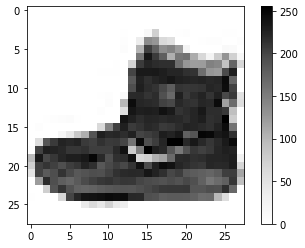

In [12]:
plt.imshow(train_imgs[0])
plt.colorbar()

* O valores serão normalizados para um intervalo de 0 a 1.

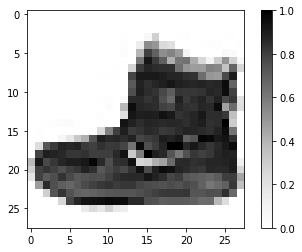

In [13]:
train_imgs = train_imgs/255.0

plt.imshow(train_imgs[0])
plt.colorbar()

# 2º Modelo: Valores normalizados [0, 1]

In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.4836


* Na execução desta observação, a perda foi reduzida de 4.4171 para 0.4825.

* Reduzir a amplitude numérica que a rede precisou processar ajudou muito a evitar perda de informação.

* As gradações das imagens se mantiveram, a roupa usada como exemplo anteriormente continuou sendo visualmente identificável, e ainda houve melhoria no modelo.

# Redução de perda: Reestruturação das camadas escondidas

* Da segunda camada para a camada de saída há conexões de 256 para 10. 

* A ideia do próximo passo é afunilar estas conexões criando uma camada internediária e verificar se a perda é reduzida.

## Segunda camada escondida: 128 neurônios

In [15]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),               # camada de entrada
    keras.layers.Dense(256, activation = tensorflow.nn.relu),   # primeira camada escondida
    keras.layers.Dense(128, activation = tensorflow.nn.relu),   # nova camda escondida, segunda camada
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)  # camada de saída
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.4815


* Na execução desta observação, a perda foi reduzida de 0.4825 para 0.4777.

## Terceira camada escondida: 64 neurônios

In [16]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(64, activation = tensorflow.nn.relu),    # terceira camada escondida
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 7s 3ms/step - loss: 0.4829


* Na execução desta observação, a perda foi incrementada de 0.4777 para 0.4854.

* Neste caso de estudo, o aumento do tempo de execução foi irrelevante.

* Aumentar a quantidade de camadas escondidas, tornando a rede mais profunda, nem sempre trará benefícios para o modelo, além de poder aumentar significativamente o tempo de execução em modelos de aplicação real.

* Tanto a quantidade de neurônios quanto as funções de ativação precisarão de uma exploração, um processo mais subjetivo do que exato.

# 3º Modelo: Normalização e 2 camadas escondidas

In [17]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 7s 3ms/step - loss: 0.4765


# Redução de perda: Quantidade de épocas

* Épocas são os contatos que o modelo tem com o dataset no processo de aprendizagem, em que os ajustes de pesos das conexões são feitas entre os neurônios.

* A seguir, as quantidades de épocas serão alteradas para análise da sua influência na perda.

* O tempo de execução terá um aumento linear, diretamente proporcional à execução com somento uma época.

In [18]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4717
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3589
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3227
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3003
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2835


* A perda foi diminindo gradativamente, mas mesmo neste dataset de estudo o aumento de tempo já foi perceptível.

# 4º Modelo: Normalização, 2 camadas escondidas, 5 épocas

In [19]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_imgs, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4747 - accuracy: 0.8294
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3611 - accuracy: 0.8666
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3247 - accuracy: 0.8798
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3020 - accuracy: 0.8875
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2842 - accuracy: 0.8937


# Métrica de avaliação: Acurácia

* A acurácia irá medir o quanto o modelo está acertando.

* O ideal é que, à medida que o modelo é reestruturado, a perda diminua e a acurácia aumente.

In [20]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_imgs, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4762 - accuracy: 0.8296
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3614 - accuracy: 0.8666
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3274 - accuracy: 0.8786
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3010 - accuracy: 0.8881
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2826 - accuracy: 0.8942


* A acurácia aumentou de acordo com a quantidade de épocas executadas.

# Testes do Modelo

## Elemento a elemento

* Sobre o modelo com as aletrações: imagens normalizadas, segunda camada escondida e 5 épocas.

In [21]:
testes = model.predict(test_imgs)

313/313 [==============================] - 1s 2ms/step


In [22]:
testes[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.99999994],
      dtype=float32)

In [23]:
np.argmax(testes[0])

9

* A Softmax, usada na camada de saída, retorna a probabilidade de uma entrada pertencer a cada categoria.

* No primeiro item do dataset, demonstrado acima, foi calculada uma probabilidade de quase 100% da imagem representar um item da última classe.

In [24]:
print(f'Resultado do teste: {np.argmax(testes[0])}')
print(f'Número da imagem de teste: {test_labels[0]}')

Resultado do teste: 9
Número da imagem de teste: 9


## Evaluate

* 1º Resultados: Perda do teste
* 2º Resultado: Acurácia do teste

In [25]:
test_loss, test_accuracy = model.evaluate(test_imgs, test_labels)
print(f'Perda: {test_loss}')
print(f'Acuráci: {test_accuracy}')

313/313 [==============================] - 1s 2ms/step - loss: 48.8358 - accuracy: 0.8626
Perda: 48.835750579833984
Acuráci: 0.8626000285148621


In [26]:
test_imgs_normalized = test_imgs/255

test_loss, test_accuracy = model.evaluate(test_imgs_normalized, test_labels)
print(f'Perda: {test_loss}')
print(f'Acuráci: {test_accuracy}')

313/313 [==============================] - 1s 2ms/step - loss: 0.3295 - accuracy: 0.8809
Perda: 0.3295125365257263
Acuráci: 0.8809000253677368


## Conjunto de Validação

* Com a definição do validation_split, o treinamento passa a separar um conjunto para validação do modelo.

* Os valores de perda e acurácia da validação são retornados junto com os do treino.

In [29]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.4918 - accuracy: 0.8236 - val_loss: 0.4152 - val_accuracy: 0.8528
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3730 - accuracy: 0.8630 - val_loss: 0.3589 - val_accuracy: 0.8694
Epoch 3/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3321 - accuracy: 0.8774 - val_loss: 0.3500 - val_accuracy: 0.8725
Epoch 4/5
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3059 - accuracy: 0.8866 - val_loss: 0.3257 - val_accuracy: 0.8828
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2868 - accuracy: 0.8934 - val_loss: 0.3298 - val_accuracy: 0.8813


# Gráficos de Acurácia e Perda

## Análise de 5 épocas

In [30]:
historico.history

{'loss': [0.49182069301605225,
  0.37302324175834656,
  0.3320867419242859,
  0.3059147894382477,
  0.2867877781391144],
 'accuracy': [0.823645830154419,
  0.8630208373069763,
  0.8774166703224182,
  0.8866458535194397,
  0.8933541774749756],
 'val_loss': [0.41522741317749023,
  0.35887056589126587,
  0.3500000536441803,
  0.32574403285980225,
  0.3298417627811432],
 'val_accuracy': [0.8527500033378601,
  0.8694166541099548,
  0.8725000023841858,
  0.8828333616256714,
  0.8813333511352539]}

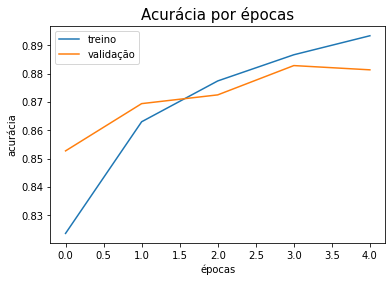

In [42]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])

plt.title('Acurácia por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino', 'validação'])
plt.show()

* A acurácia aumentou no decorrer das 5 épocas. Portanto, seguiu como desejado.

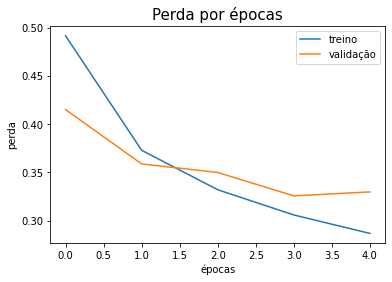

In [43]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])

plt.title('Perda por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino', 'validação'])
plt.show()

* A perda diminuiu no decorrer das 5 épocas. Também seguiu como desejado.

## Análise de 10 épocas

In [53]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 10, validation_split = 0.2)

Epoch 1/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4971 - accuracy: 0.8214 - val_loss: 0.3889 - val_accuracy: 0.8605
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3692 - accuracy: 0.8659 - val_loss: 0.3552 - val_accuracy: 0.8735
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3339 - accuracy: 0.8774 - val_loss: 0.3519 - val_accuracy: 0.8709
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3071 - accuracy: 0.8855 - val_loss: 0.3534 - val_accuracy: 0.8694
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2875 - accuracy: 0.8934 - val_loss: 0.3218 - val_accuracy: 0.8821
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2732 - accuracy: 0.8977 - val_loss: 0.3184 - val_accuracy: 0.8829
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2610 - accuracy: 0.9020 - val_loss: 0.3206 - val_accuracy:

### Acurácia

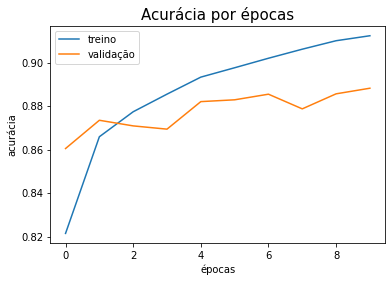

In [54]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])

plt.title('Acurácia por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino', 'validação'])
plt.show()

* A Acurácia do treino sobe de forma consistente, mas a de validação não só não consegue aumentar o suficiente para acompanhá-la como oscila no decorrer das épocas.

### Perda

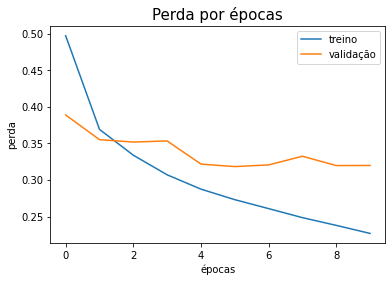

In [55]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])

plt.title('Perda por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino', 'validação'])
plt.show()

* Algo semelhante acontece com os valores de perda, a validação não consegue acompanhar o treino.

* Os dois gráficos sugereme o modelo está sofrendo um Overfitting, ou seja, está tão especializado nos padrões das imagens de treinamento que não consegue interpretar novas imagens, do conjunto de validação.

* Para evitar o oferfitting, pode-se manter a quantidade de épocas no intervalo em que os resultados estão mais estáveis. Onde a tendência da perda e da acurácia estão favoráveis no treino e os resultados na validação ainda estão próximos.

* Neste caso, entre [4, 6]. Será mantido o 4º modelo.

# Mais alterações nas camadas escondidas

## Dropout

* Irá inativar algumas ligações entre duas camadas, como se os neurônios estivessem inativos. Recebe uma porcentagem de ligações que serão desligadas.

* Pode ser considerado uma Normalização.

In [60]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dropout(0.2),  # nova camada escondida
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5192 - accuracy: 0.8145 - val_loss: 0.4135 - val_accuracy: 0.8507
Epoch 2/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3859 - accuracy: 0.8579 - val_loss: 0.3774 - val_accuracy: 0.8662
Epoch 3/5
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3468 - accuracy: 0.8711 - val_loss: 0.3519 - val_accuracy: 0.8748
Epoch 4/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3223 - accuracy: 0.8803 - val_loss: 0.3458 - val_accuracy: 0.8722
Epoch 5/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3041 - accuracy: 0.8865 - val_loss: 0.3387 - val_accuracy: 0.8767


### Gráficos de Validação

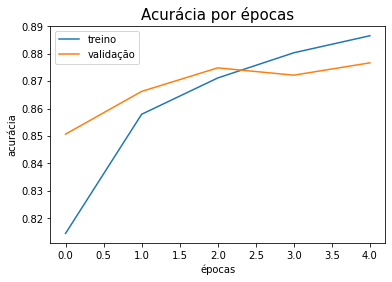

In [61]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])

plt.title('Acurácia por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino', 'validação'])
plt.show()

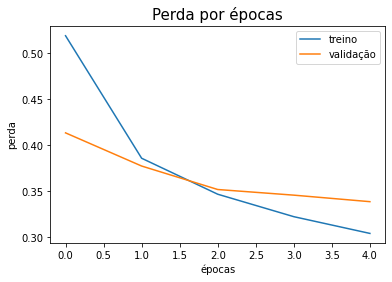

In [62]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])

plt.title('Perda por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino', 'validação'])
plt.show()

* O comportamento das curvas de validação melhoraram em comparação com o modelo sem Dropout. Apesar dos resultados de treino serem um pouco piores, a perda e acurácia da validação estão melhores.

# Salvando e utilizando modelo treinado

In [63]:
model.save('model.h5')

In [72]:
from tensorflow.keras.models import load_model

saved_model = load_model('model.h5')

In [74]:
tests = saved_model.predict(test_imgs_normalized)
print(f'Resultado do teste: {np.argmax(tests[0])}')
print(f'Rótulo da imagem: {test_labels[0]}')

313/313 [==============================] - 1s 3ms/step
Resultado do teste: 9
Rótulo da imagem: 9
